# Inspect Null Model Fits

Compare model fits and data for null (permuted) vs. actual data for a single subject.

**Parameters:** dset=nsdsyn, subj=subj01, perm=0-99, roi=V1, vs=pRFsize

**Steps:**
1. Load actual data (subj_df + precision, merged) and actual model fit
2. Load null data (100 permuted CSVs) and null model fits (100 .pt files)
3. Compare model fits and data

## Imports & Environment

In [47]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.insert(0, os.path.dirname(os.getcwd()))

import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sfp_nsdsyn import two_dimensional_model as model

with open(os.path.join(os.path.dirname(os.getcwd()), 'config.json')) as f:
    config = json.load(f)

OUTPUT_DIR = config['OUTPUT_DIR']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Parameters

In [48]:
dset = 'nsdsyn'
subj = 'subj01'
roi = 'V1'
vs = 'pRFsize'
lr = 0.0005
max_epoch = 30000
n_perm = 100
perms = np.arange(0, n_perm)

PARAMS_2D = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'p_3', 'p_4', 'A_1', 'A_2']

## Build File Paths

In [49]:
# Actual data
actual_data_path = os.path.join(
    OUTPUT_DIR, 'dataframes', dset, 'model',
    f'dset-{dset}_sub-{subj}_roi-{roi}_vs-{vs}_tavg-False.csv')
precision_path = os.path.join(
    OUTPUT_DIR, 'dataframes', dset, 'precision',
    f'precision-v_sub-{subj}_roi-{roi}_vs-{vs}.csv')

# Actual model
actual_model_path = os.path.join(
    OUTPUT_DIR, 'sfp_model', 'results_2D', dset,
    f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vs}.pt')

# Null data (permuted)
null_data_paths = [
    os.path.join(
        OUTPUT_DIR, 'dataframes', dset, 'perm', subj,
        f'perm-{p}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vs}_precision_merged.csv')
    for p in perms
]

# Null model fits
null_model_paths = [
    os.path.join(
        OUTPUT_DIR, 'sfp_model', 'results_2D', dset, 'perm', subj,
        f'perm-{p}_model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vs}.pt')
    for p in perms
]

# Verify paths exist
for label, path in [('actual data', actual_data_path), ('precision', precision_path), ('actual model', actual_model_path)]:
    exists = os.path.exists(path)
    symbol = 'OK' if exists else 'MISSING'
    print(f'[{symbol}] {label}: {path}')

null_data_exist = sum(os.path.exists(p) for p in null_data_paths)
null_model_exist = sum(os.path.exists(p) for p in null_model_paths)
print(f'Null data: {null_data_exist}/{n_perm} exist')
print(f'Null models: {null_model_exist}/{n_perm} exist')

[OK] actual data: /Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/model/dset-nsdsyn_sub-subj01_roi-V1_vs-pRFsize_tavg-False.csv
[OK] precision: /Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision/precision-v_sub-subj01_roi-V1_vs-pRFsize.csv
[OK] actual model: /Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/model-params_lr-0.0005_eph-30000_sub-subj01_roi-V1_vs-pRFsize.pt
Null data: 100/100 exist
Null models: 100/100 exist


## Load Actual Data & Model

In [50]:
# Load and merge actual data (same as run_model rule in Snakefile)
subj_df = pd.read_csv(actual_data_path)
precision_df = pd.read_csv(precision_path)
actual_data = subj_df.merge(precision_df, on=['sub', 'vroinames', 'voxel'])
actual_data = actual_data.groupby(['sub', 'voxel', 'class_idx', 'vroinames']).mean().reset_index()

actual_data.shape, actual_data.head()

((64596, 25),
       sub  voxel  class_idx vroinames   trial  image_idx  run  stim_idx  w_r  \
 0  subj01     10          0        V1  368.50      106.5  3.5       1.5  0.0   
 1  subj01     10          1        V1  373.25      110.5  3.5       5.5  0.0   
 2  subj01     10          2        V1  421.75      114.5  4.0       9.5  0.0   
 3  subj01     10          3        V1  439.25      118.5  4.5      13.5  0.0   
 4  subj01     10          4        V1  431.75      122.5  4.0      17.5  0.0   
 
     w_a  ...     angle      size  exponent         R2  visualrois  eccrois  \
 0  -6.0  ...  5.030775  0.971252  0.207034  68.512573         2.0      3.0   
 1 -11.0  ...  5.030775  0.971252  0.207034  68.512573         2.0      3.0   
 2 -20.0  ...  5.030775  0.971252  0.207034  68.512573         2.0      3.0   
 3 -37.0  ...  5.030775  0.971252  0.207034  68.512573         2.0      3.0   
 4 -69.0  ...  5.030775  0.971252  0.207034  68.512573         2.0      3.0   
 
    local_sf  local_or

In [51]:
# Load actual model
actual_model = model.load_SpatialFrequencyModel(actual_model_path)

# Extract parameters as dict
actual_params = {name: param.item() for name, param in actual_model.named_parameters()}
actual_params

{'sigma': 2.536200523376465,
 'slope': 0.1391485333442688,
 'intercept': 0.27188271284103394,
 'p_1': -0.07282158732414246,
 'p_2': 0.0031622610986232758,
 'p_3': -0.2559809982776642,
 'p_4': 0.014143886975944042,
 'A_1': 0.08079613745212555,
 'A_2': -0.015729855746030807}

## Load Null Data (Permuted)

In [52]:
null_data_list = []
for p, path in zip(perms, null_data_paths):
    df = pd.read_csv(path)
    df['perm'] = p
    null_data_list.append(df)

null_data = pd.concat(null_data_list, ignore_index=True)
null_data.shape, null_data['perm'].nunique()

((6459600, 26), 100)

## Load Null Model Fits

In [53]:
null_models_df = model.load_all_models(
    null_model_paths, *['sub', 'lr', 'eph', 'roi', 'perm'])
null_models_df['perm'] = null_models_df['perm'].astype(int)

null_models_df.shape, null_models_df.head()

((100, 14),
       sigma     slope  intercept       p_1       p_2       p_3       p_4  \
 0  8.344556  6.402747   6.478441  0.011790 -0.004045 -1.370019  0.834223   
 0  9.978989 -1.192362   7.279386  0.004018  0.005010 -0.080139 -0.911890   
 0  4.567024  0.202784   0.135557 -0.040576  0.013392 -0.373615 -0.480223   
 0  5.099609  0.030100   0.171268 -0.025558  0.036695  0.104248 -0.551046   
 0  9.119332  3.566402   3.434716 -0.000211 -0.000047 -1.412458  0.413173   
 
         A_1       A_2     sub lr_rate max_epoch vroinames  perm  
 0  0.013898 -0.001160  subj01  0.0005     30000        V1     0  
 0 -0.023003 -0.013500  subj01  0.0005     30000        V1     1  
 0 -0.000830 -0.003675  subj01  0.0005     30000        V1     2  
 0 -0.019568  0.002139  subj01  0.0005     30000        V1     3  
 0 -0.000660  0.006606  subj01  0.0005     30000        V1     4  )

## Compare Model Fit vs Data for a Single Voxel

In [54]:
import seaborn as sns

# Reconstruct stimulus class names from w_r, w_a
def label_stim_names(row):
    if row.w_r == 0 and row.w_a != 0:
        return 'pinwheel'
    elif row.w_r != 0 and row.w_a == 0:
        return 'annulus'
    elif row.w_r == row.w_a:
        return 'reverse spiral'
    elif row.w_r == -1 * row.w_a:
        return 'forward spiral'
    else:
        return 'mixtures'

actual_data['names'] = actual_data.apply(label_stim_names, axis=1)

# Pick a voxel with moderate eccentricity (2-4 deg) and 28 conditions
main_classes = ['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
voxel_counts = actual_data.groupby('voxel').size()
voxels_with_28 = voxel_counts[voxel_counts == 28].index

candidates = actual_data[
    actual_data['voxel'].isin(voxels_with_28) &
    actual_data['eccentricity'].between(2, 4)
]['voxel'].unique()

example_voxel = candidates[0]

# Extract voxel data (all 28 conditions)
vox_data = actual_data[actual_data['voxel'] == example_voxel].sort_values('class_idx')
ecc = vox_data['eccentricity'].iloc[0]
angle = vox_data['angle'].iloc[0]
vox_data[['voxel', 'class_idx', 'names', 'local_sf', 'local_ori', 'betas', 'eccentricity', 'angle']].head(10)

,voxel,class_idx,names,local_sf,local_ori,betas,eccentricity,angle
812,124,0,pinwheel,0.463726,0.409077,4.825000,2.059255,5.121466
813,124,1,pinwheel,0.850164,0.409077,5.680000,2.059255,5.121466
814,124,2,pinwheel,1.545753,0.409077,5.159583,2.059255,5.121466
815,124,3,pinwheel,2.859642,0.409077,4.601250,2.059255,5.121466
816,124,4,pinwheel,5.332846,0.409077,3.076250,2.059255,5.121466
817,124,5,pinwheel,9.892816,0.409077,4.265417,2.059255,5.121466
818,124,6,forward spiral,0.437205,1.194475,3.787500,2.059255,5.121466
819,124,7,forward spiral,0.765108,1.194475,5.138750,2.059255,5.121466
820,124,8,forward spiral,1.530217,1.194475,3.822917,2.059255,5.121466
821,124,9,forward spiral,2.841831,1.194475,4.555000,2.059255,5.121466


In [55]:
# Generate predictions for the example voxel
sf = vox_data['local_sf'].values
ori = vox_data['local_ori'].values
ecc_arr = vox_data['eccentricity'].values
angle_arr = vox_data['angle'].values
betas = vox_data['betas'].values

# Actual model predictions (28 points)
actual_pred = actual_model.forward(
    w_l=sf, theta_l=ori, r_v=ecc_arr, theta_v=angle_arr, to_numpy=True).squeeze()

# Null model predictions (perm=0)
null_params_row = null_models_df[null_models_df['perm'] == 0]
null_sfm = model.SpatialFrequencyModel(params=null_params_row)
null_pred = null_sfm.forward(
    w_l=sf, theta_l=ori, r_v=ecc_arr, theta_v=angle_arr, to_numpy=True).squeeze()

# L2-normalize betas and predictions (matching the loss function)
betas_norm = betas / np.linalg.norm(betas)
actual_pred_norm = actual_pred / np.linalg.norm(actual_pred)
null_pred_norm = null_pred / np.linalg.norm(null_pred)

# Generate smooth curves per stimulus class
sf_fine = np.geomspace(sf.min() * 0.8, sf.max() * 1.2, 100)
smooth_curves = {}
for cls in main_classes:
    cls_mask = vox_data['names'] == cls
    if not cls_mask.any():
        continue
    cls_ori = vox_data.loc[cls_mask, 'local_ori'].iloc[0]
    ori_arr_fine = np.full_like(sf_fine, cls_ori)
    ecc_arr_fine = np.full_like(sf_fine, ecc)
    angle_arr_fine = np.full_like(sf_fine, angle)

    actual_curve = actual_model.forward(
        w_l=sf_fine, theta_l=ori_arr_fine, r_v=ecc_arr_fine, theta_v=angle_arr_fine, to_numpy=True).squeeze()
    null_curve = null_sfm.forward(
        w_l=sf_fine, theta_l=ori_arr_fine, r_v=ecc_arr_fine, theta_v=angle_arr_fine, to_numpy=True).squeeze()

    # Normalize using same factor as 28-point predictions
    smooth_curves[cls] = {
        'sf': sf_fine,
        'actual': actual_curve / np.linalg.norm(actual_pred),
        'null': null_curve / np.linalg.norm(null_pred),
    }

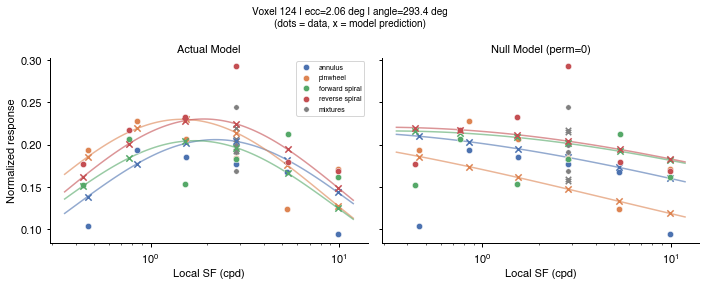

In [56]:
pal = dict(zip(main_classes, sns.color_palette("deep", 4)))
names = vox_data['names'].values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for ax, (pred_norm, title, curve_key) in zip(axes, [
    (actual_pred_norm, 'Actual Model', 'actual'),
    (null_pred_norm, 'Null Model (perm=0)', 'null'),
]):
    # Smooth curves per stimulus class
    for cls in main_classes:
        if cls in smooth_curves:
            ax.plot(smooth_curves[cls]['sf'], smooth_curves[cls][curve_key],
                    color=pal[cls], alpha=0.6, linewidth=1.5)

    # Data points and model predictions per class
    for cls in main_classes:
        mask = names == cls
        if not mask.any():
            continue
        ax.scatter(sf[mask], betas_norm[mask], color=pal[cls], s=40,
                   label=cls, zorder=5, edgecolors='white', linewidth=0.5)
        ax.scatter(sf[mask], pred_norm[mask], color=pal[cls], s=40,
                   marker='x', zorder=5, linewidths=1.5)

    # Mixtures (no smooth curve)
    mix_mask = names == 'mixtures'
    if mix_mask.any():
        ax.scatter(sf[mix_mask], betas_norm[mix_mask], color='gray', s=30,
                   label='mixtures', zorder=4, edgecolors='white', linewidth=0.5)
        ax.scatter(sf[mix_mask], pred_norm[mix_mask], color='gray', s=30,
                   marker='x', zorder=4, linewidths=1.5)

    ax.set_xscale('log')
    ax.set_xlabel('Local SF (cpd)')
    ax.set_title(title)

axes[0].set_ylabel('Normalized response')
axes[0].legend(fontsize=7, loc='upper right')
fig.suptitle(f'Voxel {example_voxel} | ecc={ecc:.2f} deg | angle={np.degrees(angle):.1f} deg\n'
             f'(dots = data, x = model prediction)',
             fontsize=10)
fig.tight_layout()

### How the smooth curves work

Each stimulus class (annulus, pinwheel, forward spiral, reverse spiral) has a **fixed local orientation** (`theta_l`) that stays the same across all spatial frequency levels. For example, all 6 annulus stimuli share the same `local_ori`.

The smooth curves are generated by evaluating the model's `forward(w_l, theta_l, r_v, theta_v)` on a dense grid of 100 spatial frequencies (`sf_fine`, log-spaced), while holding:
- `theta_l` fixed at that class's characteristic orientation
- `r_v` and `theta_v` fixed at the example voxel's eccentricity and angle

This traces out the model's continuous SF tuning function for one specific orientation. Each class gets a **different curve** because each has a different `theta_l`.

For the **null model** (right panel), the same procedure is applied but using the null model's 9 parameters. The shape of the tuning curves differs because the null model was fit to shuffled data, so its parameters are different.

**Normalization**: Both the 28-point predictions and the smooth curves are divided by the L2 norm of the 28-point predictions. This matches the L2 normalization used in the loss function during model fitting. The smooth curves use the *same* normalization factor (not their own norm) to keep them on the same scale as the discrete prediction points.

## Null Model Parameter Distributions

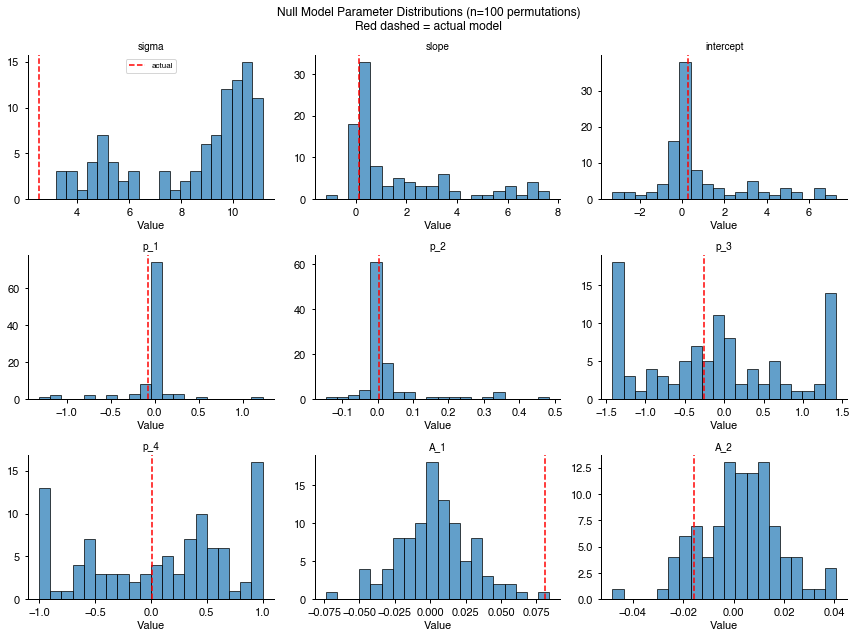

In [ ]:
.
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for ax, param in zip(axes.flat, PARAMS_2D):
    ax.hist(null_models_df[param].values, bins=20, alpha=0.7, edgecolor='black')
    ax.axvline(actual_params[param], color='red', linestyle='--', linewidth=1.5, label='actual')
    ax.set_title(param, fontsize=10)
    ax.set_xlabel('Value')
axes.flat[0].legend(fontsize=8)
fig.suptitle(f'Null Model Parameter Distributions (n={n_perm} permutations)\nRed dashed = actual model', fontsize=12)
fig.tight_layout()

## Model Prediction vs Null Data as a Function of Each Parameter

For one stimulus condition of the example voxel, plot the null model prediction and null data beta against each parameter's value across all permutations. This reveals which parameters systematically drive prediction magnitude.

Note: each null model has all 9 parameters varying simultaneously, so correlations reflect both the direct effect of that parameter and confounding from the other 8.

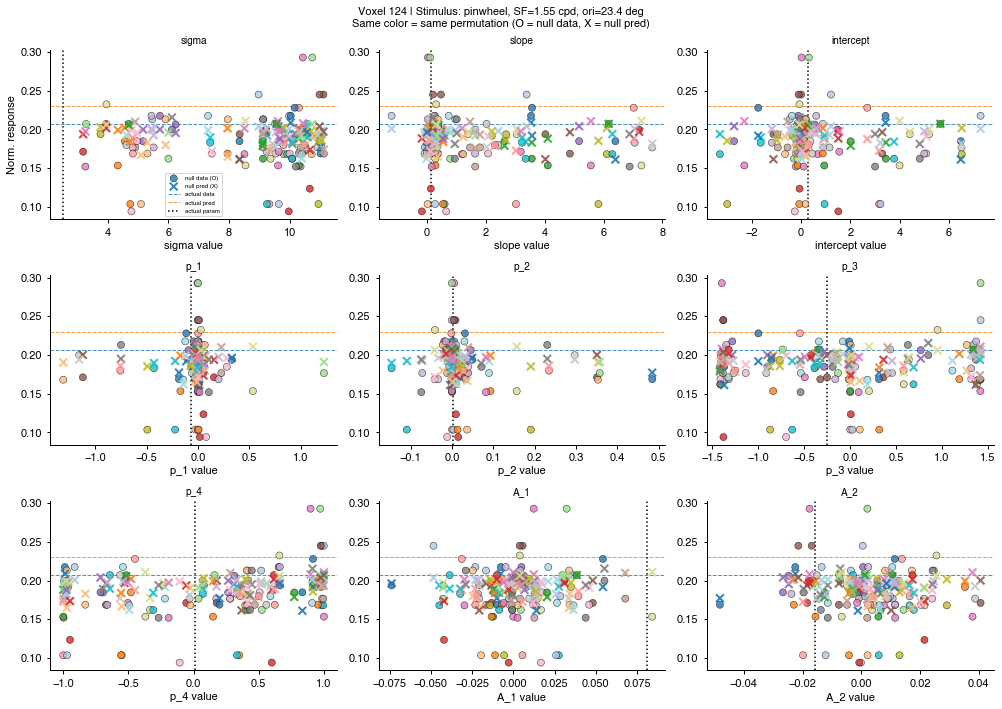

In [58]:
# Generate predictions from all null models for the example voxel
null_preds = {}
for _, row in null_models_df.iterrows():
    p = int(row['perm'])
    sfm = model.SpatialFrequencyModel(params=row)
    pred = sfm.forward(w_l=sf, theta_l=ori, r_v=ecc_arr, theta_v=angle_arr, to_numpy=True).squeeze()
    null_preds[p] = pred / np.linalg.norm(pred)

# Extract null data (shuffled betas) for the example voxel from each permutation
null_betas_dict = {}
for p in perms:
    vox = null_data[(null_data['perm'] == p) & (null_data['voxel'] == example_voxel)].sort_values('class_idx')
    b = vox['betas'].values
    null_betas_dict[p] = b / np.linalg.norm(b)

# Pick one stimulus: mid-SF from first class (class_idx=2, pinwheel ~1.5 cpd)
stim_idx = 2
stim_sf = sf[stim_idx]
stim_ori = ori[stim_idx]
stim_name = vox_data.iloc[stim_idx]['names']

# Extract prediction and data at this one stimulus across all permutations
pred_at_stim = np.array([null_preds[p][stim_idx] for p in perms])
beta_at_stim = np.array([null_betas_dict[p][stim_idx] for p in perms])

# Actual model references
actual_pred_at_stim = actual_pred_norm[stim_idx]
actual_beta_at_stim = betas_norm[stim_idx]

# Build param-value lookup
param_by_perm = null_models_df.set_index('perm')[PARAMS_2D]

# Color each permutation consistently
cmap = plt.cm.tab20
perm_colors = [cmap(p % 20) for p in perms]

# Plot 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
for ax, param in zip(axes.flat, PARAMS_2D):
    param_vals = param_by_perm[param].values

    ax.scatter(param_vals, beta_at_stim, s=50, alpha=0.8, c=perm_colors,
               edgecolors='black', linewidth=0.5, label='null data (O)', zorder=5)
    ax.scatter(param_vals, pred_at_stim, s=60, alpha=0.9, c=perm_colors,
               marker='x', linewidths=2, label='null pred (X)', zorder=6)
    ax.axhline(actual_beta_at_stim, color='C0', linestyle='--', alpha=0.8, linewidth=1, label='actual data')
    ax.axhline(actual_pred_at_stim, color='C1', linestyle='--', alpha=0.8, linewidth=1, label='actual pred')
    ax.axvline(actual_params[param], color='black', linestyle=':', linewidth=1.5, label='actual param')

    ax.set_title(param, fontsize=10)
    ax.set_xlabel(f'{param} value')

axes[0, 0].set_ylabel('Norm. response')
axes[0, 0].legend(fontsize=6, loc='best')
fig.suptitle(f'Voxel {example_voxel} | Stimulus: {stim_name}, SF={stim_sf:.2f} cpd, ori={np.degrees(stim_ori):.1f} deg\n'
             f'Same color = same permutation (O = null data, X = null pred)', fontsize=11)
fig.tight_layout()

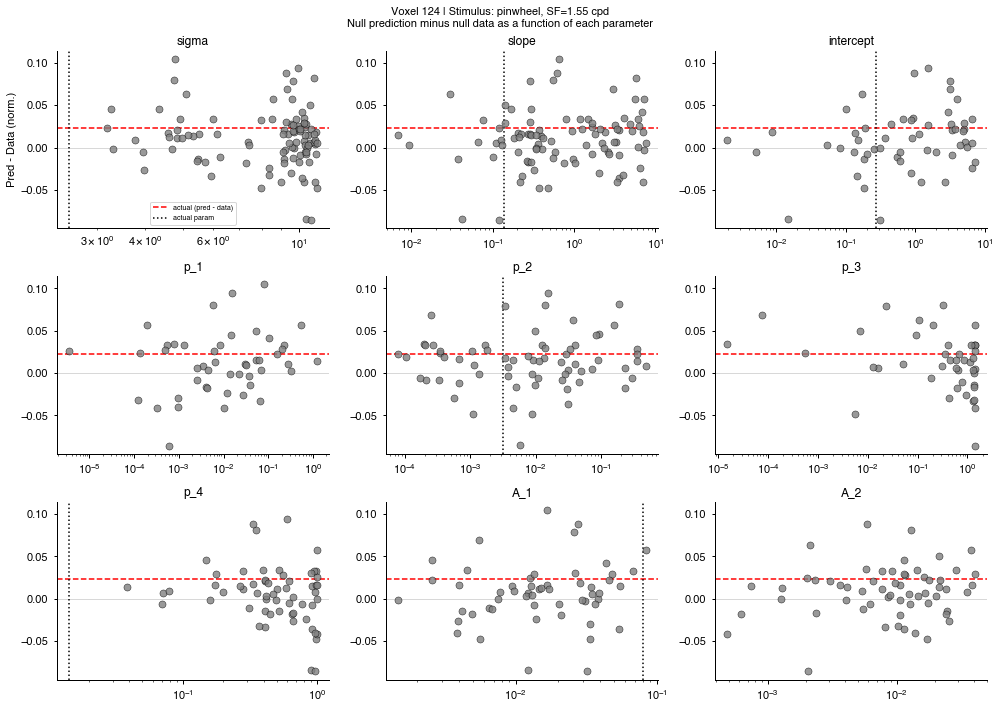

In [61]:
# Difference between null prediction and null data at the chosen stimulus
diff_at_stim = pred_at_stim - beta_at_stim
actual_diff = actual_pred_at_stim - actual_beta_at_stim

fig, axes = plt.subplots(3, 3, figsize=(14, 10))
for ax, param in zip(axes.flat, PARAMS_2D):
    param_vals = param_by_perm[param].values

    ax.scatter(param_vals, diff_at_stim, s=50, alpha=0.8, c='gray',
               edgecolors='black', linewidth=0.5, zorder=5)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axhline(actual_diff, color='red', linestyle='--', linewidth=1.5, label='actual (pred - data)')
    ax.axvline(actual_params[param], color='black', linestyle=':', linewidth=1.5, label='actual param')

    ax.set_title(param, fontsize=12)
    ax.set_xlabel('')
    ax.set_xscale('log')

axes[0, 0].set_ylabel('Pred - Data (norm.)')
axes[0, 0].legend(fontsize=7, loc='best')
fig.suptitle(f'Voxel {example_voxel} | Stimulus: {stim_name}, SF={stim_sf:.2f} cpd\n'
             f'Null prediction minus null data as a function of each parameter', fontsize=11)
fig.tight_layout()